In [81]:
import numpy as np
import numpy.random as r#.normal
import pandas as pd
import matplotlib.pyplot as plt
import random

from importlib import reload

import kalman
reload(kalman)

<module 'kalman' from 'c:\\Users\\Alex\\Desktop\\SEB\\Tests\\kalman.py'>

In [82]:
DISTURBANCE_MAGNITUDE = 0.1
TERMINAL_VELOCITY = -20
g = -9.8
DELTA_T = 20e-3 #interval in seconds

rnjesus = r.default_rng()

In [83]:
x = np.matrix([[0.],  #pos
              [1.],  # velocity
              [2.]]) # accel

F = np.matrix([[1, DELTA_T, DELTA_T**2 / 2],  #state transition matrix
              [0, 1, DELTA_T],
              [0, 0, 1]])

sigma_b = 0.25 # barometer
sigma_a = 0.25 # accelerometer

R = np.matrix([[sigma_b**2, 0],
              [0, sigma_a**2]])

In [84]:
# def update(x_0, v, a, delta_t):
#     val = x_0 + v*delta_t+(a*delta_t**2)/2
#     #print("{}, {}, {}".format(val, disturbance_factor, val*disturbance_factor))
#     velocity = (val - x_0) / delta_t
#     with_error = val
#     if(val > 1000):
#         disturbance = random.uniform(-1,1)*DISTURBANCE_MAGNITUDE*val
#         with_error += disturbance
#     return val, velocity, with_error


a_max = 50
t_ramp_up = 0.1
t_hold = 8
t_ramp_down = 0.6

def acceleration(time):
    
    if(time < t_ramp_up):
        return time * (a_max + g) / t_ramp_up
    elif(time < (t_ramp_up + t_hold)):
        return a_max + g
    elif (time < (t_ramp_up + t_hold + t_ramp_down)):
        return a_max - (time- (t_ramp_up + t_hold)) * a_max / t_ramp_down + g
    else :
        return 0 + g

def generate_data(noisy = False):
    state = []
    x = np.matrix([[10], [5], [0]])
    t = 0
    while (x[0,0] > 0):
        pos_disturbance = 0 if not noisy or t < t_ramp_up else rnjesus.normal(0, sigma_b, 1)
        x[0,0] += pos_disturbance
        velocity_disturbance = 0 if not noisy else rnjesus.normal(0, sigma_b, 1)
        x[1,0] += velocity_disturbance
        x = F@x
        t += DELTA_T
        accel_disturbance = 0 if not noisy else rnjesus.normal(0, sigma_a, 1)
        x[2,0] = acceleration(t) + accel_disturbance
        state.append(x)
    return np.asarray(state), np.linspace(0, t, len(state))
    

In [85]:
raw_data, T = generate_data(True)

# Here to make sure that we get data that can represent an actual test
while(len(T) < 100):
    raw_data, T = generate_data(True)

print("total time: {} s".format(T[-1]))
print("num steps: {}".format(len(raw_data)))

total time: 79.1200000000014 s
num steps: 3956


No handles with labels found to put in legend.


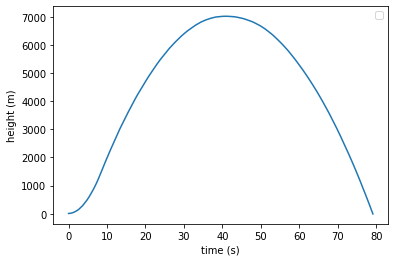

No handles with labels found to put in legend.


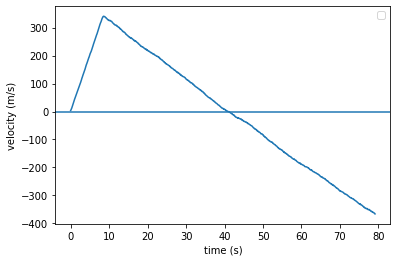

No handles with labels found to put in legend.


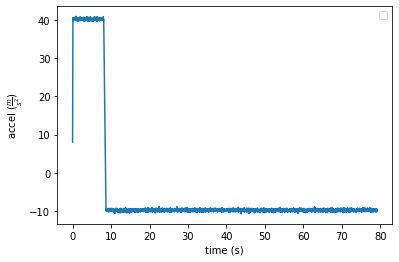

In [86]:
kalman.plot_states(T, raw_data)

$$x_k = F x_{k-1} + B a_k$$

In [87]:
""" converge K
for i in range(50):
    S = (H@P)@H.T + R
    K = (P@H.T)@np.linalg.inv(S)
    P = (np.identity(3) - K@H)@P
    P = A@(P@A.T) + Q
"""
    
H = np.matrix([[1, 0, 0],
               [0, 0, 1]])

#print(K)
print(H)
#print(P)

[[1 0 0]
 [0 0 1]]


# Various K matrices at end of filtering for different runs.
Exactly match

[[1.41321392e-03 1.21113413e-07]
 [9.99293022e-04 1.71572729e-04]
 [1.21113413e-07 8.28427125e-01]]
 
 [[1.41321392e-03 1.21113413e-07]
  [9.99293022e-04 1.71572729e-04]
  [1.21113413e-07 8.28427125e-01]]
  
 [[1.41321392e-03 1.21113413e-07]
  [9.99293022e-04 1.71572729e-04]
  [1.21113413e-07 8.28427125e-01]]

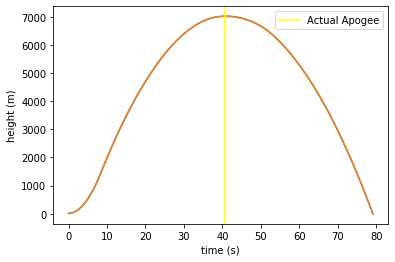

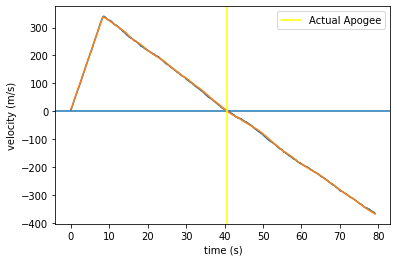

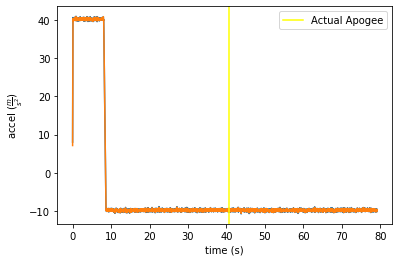

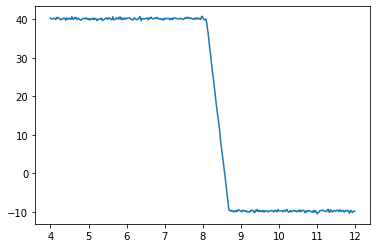

In [88]:
#create vector of measurements
z = np.asarray([H@x for x in raw_data])

filtered_data = kalman.kalman(z)
kalman.plot_states(T, raw_data, state_2=filtered_data)
plt.plot(T[200:600], filtered_data[200:600,2, 0])

2039


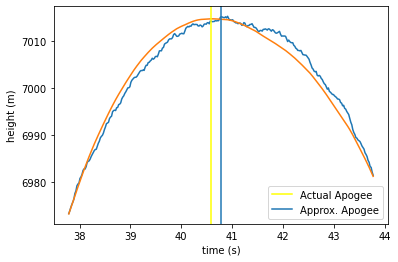

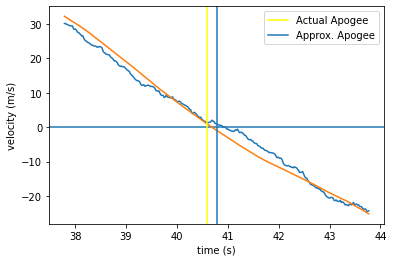

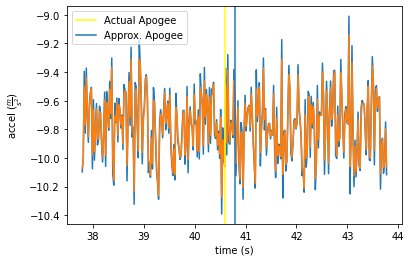

Actual - Approx Apogee = 0.2001(s)


In [89]:
# Index of apogee w/ respect to time array T
apogee_idx = kalman.Apogee(filtered_data)
print(apogee_idx)
kalman.plot_states(T, raw_data, filtered_data, apogee_idx)

# Stats for Kalman Filter Apogee Detection Accuracy

In [90]:
stats = [] #List of time it took to detect apogee
err = [] # List of Lists containing [time, raw_data, filtered_data] for further analysis
runs = 1000

for i in range(runs):
    r_data, T = generate_data(True)
    z = np.asarray([H@x for x in r_data])
    filt_data = kalman.kalman(z)
    apogee = T[kalman.Apogee(filt_data)]
    actual_apogee = T[kalman.actApogee(filt_data)]
    diff = apogee - actual_apogee
    if(diff < 0 or diff > 1):
        kalman.plot_states(T, r_data, filt_data, kalman.Apogee(filt_data))
        err.append([T, r_data, filt_data])
    else:
        stats.append(diff)

stats_np = np.asarray(stats)
print('Num of Runs: ' + str(runs))
print('Num of Successful Runs: ' + str(len(stats)))
print('Num of Erroneous Runs: ' + str(len(err)))
print('Avg Diff: ' + str(np.mean(stats_np)))
print('Max: ' + str(np.max(stats_np)))
print('Min: ' + str(np.min(stats_np)))
print('Variance: ' + str(np.var(stats_np)))

Num of Runs: 1000
Num of Successful Runs: 1000
Num of Erroneous Runs: 0
Avg Diff: 0.21155173812417663
Max: 0.7201720019111377
Min: 0.20004490345756665
Variance: 0.0018330446347067193
